# El objetivo general de esta prueba es alcanzar el mejor desempeño posible para clasificar si un tweet es positivo o negativo.
## Para medir el desempeño, se evaluará con un conjunto de datos del cuál no tendrán acceso. De esta manera evitaremos que los modelos aprendan información sobre el conjunto de validación.
### Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook, archivos auxiliares y csv). Una vez terminada la prueba, comprime la carpeta y sube el .zip a la sección correspondiente.


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
import random
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stap = stopwords.words("english")
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
lmtzr = WordNetLemmatizer()
from nltk.stem.lancaster import LancasterStemmer
st = LancasterStemmer()
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
import re
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rendo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rendo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import string

In [3]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

# 1.-Generar un análisis exploratorio sobre los datos contenidos en el DataFrame, considerando palabras más comunes y distribución de las clases en el vector objetivo. 

In [31]:
#LO QUE HAREMOS, SERÁ CREAR MODELOS DE REGRESIÓN LOGÍSTICA, BAYES, ARBOLES DE DECISIÓN, RANDOMFORESTCLASS, SVM, LDA, Adaboost Y Gradiente BUSCANDO LOS MEJORES HIPERPARÁMETROS CON GRIDSEARCH. 

In [5]:
df = pd.read_csv("training_tweets.csv").drop(columns=["Unnamed: 0"])

In [6]:
df["sentiment"].unique()

array(['love', 'worry', 'happiness', 'neutral', 'fun', 'hate', 'sadness',
       'empty', 'relief', 'surprise', 'enthusiasm', 'boredom', 'anger'],
      dtype=object)

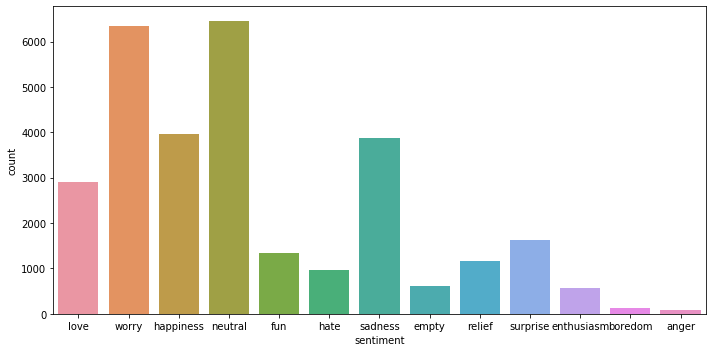

In [7]:
plt.figure(figsize=(10,5))
sns.countplot(df["sentiment"])
plt.tight_layout()

##### 3. Preparación del vector objetivo y las matrices de entrenamiento y validación:


In [8]:
df['sentiment'] = df['sentiment'].map({'love':1,'worry':-1,'happiness':1,'fun':1,'hate':-1,'sadness':-1,'empty':-1,'relief':1,'surprise':1,'enthusiasm':1,'boredom':-1,'anger':-1})

In [9]:
def cambiar_de_a_poco(Dataframe, col):
    from nltk.corpus import stopwords
    stap = stopwords.words("english")
    Dataframe[col] = Dataframe[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stap)])) #Saca stopwords
    Dataframe[col] = Dataframe[col].apply(lambda x: ' '. join([word.lower() for word in x.split()])) #minúsculas
    Dataframe[col] = pd.Series(map(lambda x: re.sub("((www\.[^\s]+)|(https?://[^\s]+))", "", x), Dataframe[col])) #Convierte url's 
    Dataframe[col] = pd.Series(map(lambda x: re.sub("@[^\s]+", "", x), Dataframe[col])) #Elimina usuarios
    Dataframe[col] = pd.Series(map(lambda x: re.sub(r"#([^\s]+)", r"\1", x), Dataframe[col])) #Saca los Hashtags
    Dataframe[col] = pd.Series(map(lambda x: re.sub('[\s]+', ' ', x), Dataframe[col]))  #Elimina dobles espacios
    Dataframe[col] = pd.Series(map(lambda x: "".join([char for char in x if char not in string.punctuation]), Dataframe[col])) #Eliminar puntuación
    Dataframe[col] = pd.Series(map(lambda x: "".join([char for char in x if char not in string.punctuation]), Dataframe[col])) #Eliminar puntuación
    Dataframe[col] = Dataframe[col].apply(lambda x: ' '. join([lmtzr.lemmatize(word) for word in x.split()])) #Generaliza palabras

In [10]:
cambiar_de_a_poco(df, "content")

In [11]:
df.head(6)

content  sentiment
0                              happy mama day mother        1.0
1                  i lost please help find good home       -1.0
2  yes yes i am networking whore fullestand girl ...        1.0
3                   you wish would tweet followed me        NaN
4  microeconomics project ihate subject amp besid...       -1.0
5  lmao lucky it 10 minute foot e schoollol on bu...        NaN

In [12]:
df2 = df.drop(index=df[df.sentiment.isna()].index)

#### se borraron los index donde son null

In [13]:
df2.head(6)

content  sentiment
0                              happy mama day mother        1.0
1                  i lost please help find good home       -1.0
2  yes yes i am networking whore fullestand girl ...        1.0
4  microeconomics project ihate subject amp besid...       -1.0
6  first thought bar life meant partying nonstop ...        1.0
7               fighter christina aguilera love song        1.0

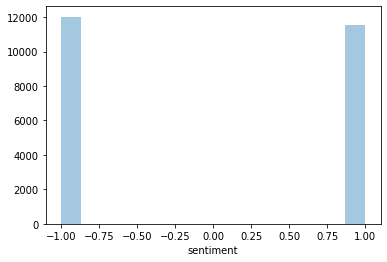

In [16]:
sns.distplot(df2["sentiment"], kde=False)

<BarContainer object of 100 artists>

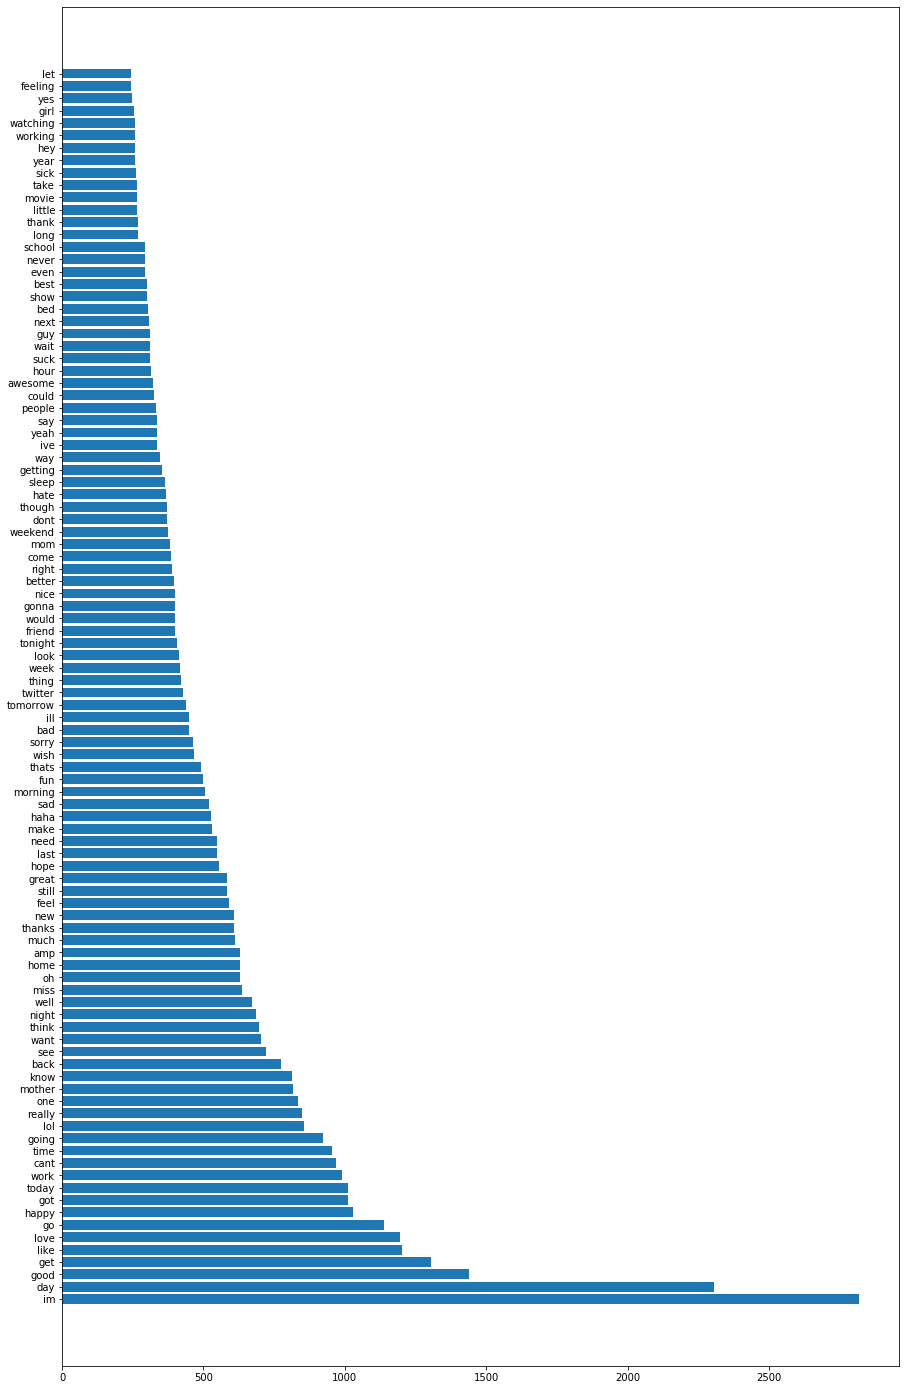

In [27]:
count_vectorizer = CountVectorizer(stop_words=stap, lowercase=True)
count_vectorizer_fit = count_vectorizer.fit_transform(df2["content"])
words = count_vectorizer.get_feature_names()
words_freq = count_vectorizer_fit.toarray().sum(axis=0)
aux = pd.DataFrame([words, words_freq]).T
aux.columns = ["Palabra", "Freq"]
aux = aux.sort_values(by=['Freq'],ascending=False)
plt.figure(figsize=(15,25))
plt.barh(y=aux["Palabra"][:100], width=aux["Freq"][:100])

In [11]:
#Las palabras más utilizadas que puedes servir para discriminar el sentimiento que hay detrás de las palabras.

####  Entrenamiento de modelos: En base a los modelos vistos en clase, implemente por lo menos 5. Para cada uno de ellos justifique la elección de hiperparámetros. Si implementa búsqueda de grilla para cada uno de ellos, defina el rango de valores a tomar en cada hiperparámetro. Reporte el desempeño de cada modelo en las muestras de entrenamiento y validación. Comente sobre la capacidad de generalización de cada uno de ellos haciendo uso de los conceptos vistos en el curso. 

In [25]:
reglog = LogisticRegression(n_jobs=-1, random_state=2503)
naiveBayes = BernoulliNB(fit_prior=False)
TreeClass = DecisionTreeClassifier(random_state=2503)
SVCClass = SVC(random_state=2503)
lda = LatentDirichletAllocation(learning_method="online", n_components=2)
RandomClass = RandomForestClassifier(random_state=2503)
modelo_adaboost = AdaBoostClassifier(random_state=253)
modelo_gradiente = GradientBoostingClassifier(random_state=253)

In [24]:
paramsreglog = {"C":[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], "fit_intercept": [True, False], "max_iter": [50, 100, 250, 500, 1000]}
paramslda= {"learning_decay": [0.8, 0.7, 0.6, 0.5, 0.4]}
paramsnaive = {"alpha": [0.5, 0.7, 1]}
paramsTree = {"max_depth": np.linspace(1,32,32), "max_features": np.linspace(1,9,9, dtype=int)}
paramssvc = {"C":[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], "gamma": [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
paramsrandomf = {"max_depth": [1, 5, 10, 20, 30, 50, 100], "learning_decay": [0.8, 0.7, 0.6, 0.5, 0.4], "n_estimators": np.linspace(20, 1000, 21, dtype=int)}
params_adaboost= {'learning_rate': [0.01, 0.1,0.3, 0.5, 0.8],'n_estimators': [50, 100, 250, 500, 1000, 2000]}
params_gradient = {'learning_rate': [0.01, 0.1,0.3,0.5, 0.8],'n_estimators': [50, 100, 250, 500, 1000, 2000],'subsample': [0.1,0.5,0.7, 0.9]}

In [26]:
gridreglog = GridSearchCV(reglog, param_grid=paramsreglog, cv=10, n_jobs = -1)
gridlda = GridSearchCV(lda, param_grid=paramslda, cv=10, n_jobs=-1)
gridbayes = GridSearchCV(naiveBayes, param_grid=paramsnaive, cv=10, n_jobs=-1)
gridtree = GridSearchCV(TreeClass, param_grid=paramsTree, cv=10, n_jobs=-1)
gridsvc = GridSearchCV(SVCClass, param_grid=paramssvc, cv=5, n_jobs=-1)
gridrandomf = GridSearchCV(RandomClass, param_grid=paramsrandomf, cv=10, n_jobs=-1)
gridada = GridSearchCV(modelo_adaboost, params_adaboost, cv=10, n_jobs=-1)
gridgradiente = GridSearchCV(modelo_gradiente, params_gradient, cv=10, n_jobs=-1)

In [28]:
x_train, x_test, y_train, y_test = train_test_split(count_vectorizer_fit, df2["sentiment"], test_size=.33, random_state = 2503)

In [30]:
%%time
gridreglog.fit(x_train, y_train)

Wall time: 2min 9s


C:\Users\rendo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\rendo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=-1, penalty='l2',
                                          random_state=2503, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'fit_intercept': [True, False],
                         'max_iter': [50, 100, 250, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [17]:
%%time
#gridlda.fit(x_train, y_train)

Wall time: 0 ns


In [18]:
%%time
#gridbayes.fit(x_train, y_train)

Wall time: 0 ns


In [19]:
%%time
#gridtree.fit(x_train, y_train)

Wall time: 0 ns


In [20]:
%%time
#gridsvc.fit(x_train, y_train)

Wall time: 0 ns


In [21]:
%%time
#gridranfomf.fit(x_train, y_train)

Wall time: 0 ns


In [22]:
model_nn = Sequential()
model_nn.add(Dense(layer1, input_shape=(features,), activation='relu'))
model_nn.add(Dropout(drop))
model_nn.add(Dense(layer2, activation='sigmoid'))
model_nn.add(Dropout(drop))
model_nn.add(Dense(3, activation='softmax'))
    
optimizer = keras.optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=epsilon, 
                                      decay=0.0, amsgrad=False)
    model_nn.compile(loss='sparse_categorical_crossentropy',
                 optimizer=optimizer,
                 metrics=['accuracy'])
    model_nn.fit(np.array(X_train_mod), y_train,
                 batch_size=32,
                 epochs=1000,
                 verbose=1,
                 validation_split=validation,
                 shuffle=shuffle)


IndentationError: unexpected indent (<ipython-input-22-34ec53eda75e>, line 10)